# 3.1 Build models

In [35]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.externals import joblib
import xgboost as xgb
import os

def sound():
    os.system('afplay /System/Library/Sounds/Sosumi.aiff')

%matplotlib inline
# sns.set_context('notebook')

path = '/'.join(os.getcwd().split('/')[:-2])
print(path)

/Volumes/Dropbox/largetransfer/luc/carter


In [36]:
rfc = joblib.load(path+'/data/models/rfc2.pkl') 
lr = joblib.load(path+'/data/models/lr2.pkl') 
gbm = xgb.Booster() #init model
gbm.load_model(path+'/data/models/gbm2.pkl')

In [41]:
rng = pd.date_range('10/1/2009', periods=23, freq='3MS')
all_preds = pd.DataFrame()
for date in rng:

    df = pd.read_csv(path+'/data/model_data/tci_3_0_'+str(date.year)+'_'+str(date.month)+'.csv', index_col=0)
    features = list(df.columns)
    features.remove('vacant')
#     features.remove('Date')
#     features.remove('Survey Category')
#     features.remove('Survey Grade')
#     features.remove('SPA_NAME')
#     features.remove('style_filtered')
#     features.remove('LENDER_PROCESS_TYPE')

#     from sklearn.cross_validation import train_test_split
#     X_train, X_test, y_train, y_test = train_test_split(df[features], df['vacant'], test_size=0.2, random_state=42)
    dmat = xgb.DMatrix(df[features])
#     preds
    pred_r = rfc.predict_proba(df[features])
    pred_g = gbm.predict(dmat)
    pred_l = lr.predict_proba(df[features])
    preds = pd.concat([pd.DataFrame(pred_r[:,1], index=df.index).rename(columns={0:'rf'}),\
           pd.DataFrame(pred_l[:,1], index=df.index).rename(columns={0:'lr'}),\
           pd.DataFrame(pred_g, index=df.index).rename(columns={0:'gbm'}),\
           df[['pv_count']]], axis=1).reset_index()
    preds['date'] = date
    all_preds = pd.concat([all_preds, preds], axis=0)
#     preds[preds.index==date]
    print(date, sum(pd.Series(gbm.predict(dmat)).apply(lambda x: 0 if x < 0.3 else 1)), \
          sum(pd.Series(pred_r[:,1]).apply(lambda x: 0 if x < 0.4 else 1)),\
          sum(pd.Series(pred_l[:,1]).apply(lambda x: 0 if x < 0.5 else 1)))
all_preds.to_csv(path+'/outputs/all_predictions2.csv')

2009-10-01 00:00:00 6328 8385 19563
2010-01-01 00:00:00 6969 8541 17026
2010-04-01 00:00:00 7184 9152 20865
2010-07-01 00:00:00 7879 8464 16246
2010-10-01 00:00:00 6497 8744 14126
2011-01-01 00:00:00 6255 8904 14071
2011-04-01 00:00:00 6445 9812 14548
2011-07-01 00:00:00 6342 9495 12893
2011-10-01 00:00:00 6026 8837 11043
2012-01-01 00:00:00 6347 8711 10474
2012-04-01 00:00:00 7900 9132 11987
2012-07-01 00:00:00 7278 9794 10682
2012-10-01 00:00:00 7598 9432 9871
2013-01-01 00:00:00 8566 9727 9499
2013-04-01 00:00:00 9076 11533 12448
2013-07-01 00:00:00 9040 11593 12017
2013-10-01 00:00:00 8375 11014 11286
2014-01-01 00:00:00 8473 11038 10919
2014-04-01 00:00:00 8808 12012 11324
2014-07-01 00:00:00 8986 11979 10945
2014-10-01 00:00:00 8572 11556 10504
2015-01-01 00:00:00 9266 13028 11366
2015-04-01 00:00:00 8937 12738 10919


In [39]:
all_preds = pd.read_csv(path+'/outputs/all_predictions2.csv', index_col=0, parse_dates=['date'])

In [42]:
all_preds.shape

(2602036, 6)

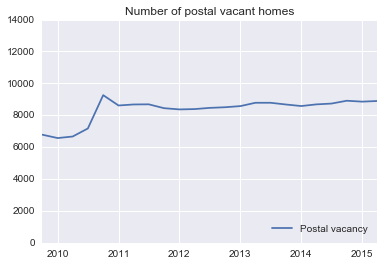

In [43]:
plt.plot(all_preds[all_preds.pv_count>0].groupby('date').count().gbm)
plt.title('Number of postal vacant homes')

plt.ylim([0,14000])
plt.legend(['Postal vacancy'], loc='lower right')
# plt.savefig(path+'/outputs/thresholds/pv.png')

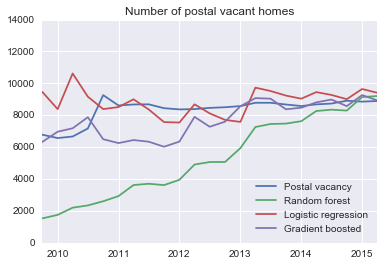

In [44]:
plt.plot(all_preds[all_preds.pv_count>0].groupby('date').count().gbm,)
plt.plot(all_preds[all_preds.rf>0.55].groupby('date').count().gbm)
plt.plot(all_preds[all_preds.lr>0.6].groupby('date').count().gbm)
plt.plot(all_preds[all_preds.gbm>0.3].groupby('date').count().gbm)

plt.title('Number of postal vacant homes')
# plt.savefig(path+'/outputs/thresholds/pv.png')
plt.ylim([0,14000])
plt.legend(['Postal vacancy','Random forest','Logistic regression','Gradient boosted'], loc='lower right')

In [ ]:
plt.title('Random forest model at different thresholds')
plt.plot(all_preds[all_preds.rf>0.4].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.rf>0.45].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.rf>0.5].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.rf>0.55].groupby('date').count().gbm, linewidth=3)
plt.plot(all_preds[all_preds.rf>0.6].groupby('date').count().gbm,'--')
plt.legend(['0.4','0.45','0.5','0.55','0.6'], loc='lower right')
plt.ylim([0,14000])
# plt.savefig(path+'/outputs/thresholds/rf.png')

In [ ]:
# plt.plot(all_preds[all_preds.lr>0.4].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.lr>0.55].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.lr>0.6].groupby('date').count().gbm,linewidth=3)
plt.plot(all_preds[all_preds.lr>0.65].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.lr>0.7].groupby('date').count().gbm,'--')
plt.title('Logistic regression model at different thresholds')
plt.legend(['0.55','0.6','0.65','.7'], loc='upper right')
plt.ylim([0,14000])
# plt.savefig(path+'/outputs/thresholds/lr.png')

In [ ]:
plt.plot(all_preds[all_preds.gbm>0.2].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.gbm>0.25].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.gbm>0.3].groupby('date').count().gbm,linewidth=3)
plt.plot(all_preds[all_preds.gbm>0.4].groupby('date').count().gbm,'--')
plt.plot(all_preds[all_preds.gbm>0.5].groupby('date').count().gbm,'--')
plt.title('Gradient boosted model at different thresholds')
plt.legend(['0.2','0.25','0.3','0.4','0.5'], loc='lower right')
plt.ylim([0,14000])

# plt.savefig(path+'/outputs/thresholds/gb.png')


## Importances

In [ ]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

In [ ]:
# Print the feature ranking
features2 = pd.DataFrame(features).iloc[indices[0:10]][0].values

print("Feature ranking (least important):")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[-10:]], yerr=std[indices[-10:]], align="center")
plt.xticks(range(10), indices[-10:])
plt.xlim([-1, 10])
plt.show()

In [ ]:
tem = pd.concat([res[['correct']].iloc[range(0,22,2)], \
           log_res[['correct']].iloc[range(0,22,2)],\
           xgb_res[['correct']].iloc[range(0,22,2)] ], axis=1)

tem.columns = ['Random forest','Logistic regression','Gradient boosted']

tem